In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
house = fetch_california_housing()
print(house.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
house.data.shape, house.target.shape

((20640, 8), (20640,))

In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    house.data, house.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(11610, 8) (11610,)
(5160, 8) (5160,)
(3870, 8) (3870,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [6]:
'''
使用sklearn进行超参数搜索
# 1、将模型转化为sklearn的model；2、定义参数集合；3、搜索参数
'''
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers-1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model) # 封装为sklearn model
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
history = sklearn_model.fit(x_train_scaled, y_train,
                            validation_data=(x_valid_scaled, y_valid),
                            epochs=100,
                            callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 147us/sample - loss: 1.4402 - val_loss: 0.8322
Epoch 2/100
11610/11610 [==============================] - 1s 105us/sample - loss: 0.7245 - val_loss: 0.6768
Epoch 3/100
11610/11610 [==============================] - 1s 76us/sample - loss: 0.5946 - val_loss: 0.6277
Epoch 4/100
11610/11610 [==============================] - 1s 78us/sample - loss: 0.5394 - val_loss: 0.5613
Epoch 5/100
11610/11610 [==============================] - 1s 76us/sample - loss: 0.5130 - val_loss: 0.5370
Epoch 6/100
11610/11610 [==============================] - 1s 79us/sample - loss: 0.4945 - val_loss: 0.5241
Epoch 7/100
11610/11610 [==============================] - 1s 108us/sample - loss: 0.4825 - val_loss: 0.5039
Epoch 8/100
11610/11610 [==============================] - 1s 79us/sample - loss: 0.4682 - val_loss: 0.4929
Epoch 9/100
11610/11610 [==============================] - 1s 96us/sample - loss: 0.

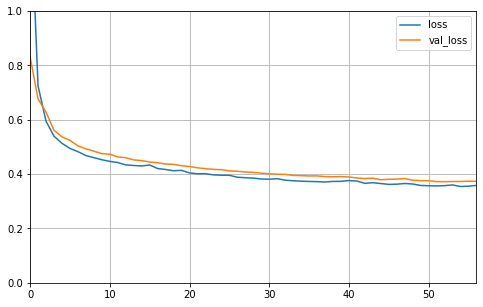

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [8]:

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribution = {
    'hidden_layers': [1, 2, 3, 4],
    'layer_size': np.arange(1, 100),
    'learning_rate': reciprocal(1e-4, 1e-2)
}
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution, n_iter=10, n_jobs=1)
random_search_cv.fit(x_train_scaled, y_train, epochs=100,
                     validation_data=(x_valid_scaled, y_valid),
                     callbacks = callbacks)

/home/kdd/Env/TF2.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 197us/sample - loss: 0.8541 - val_loss: 0.5539
Epoch 2/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.5111 - val_loss: 0.4938
Epoch 3/100
7740/7740 [==============================] - 1s 111us/sample - loss: 0.4265 - val_loss: 0.4231
Epoch 4/100
7740/7740 [==============================] - 1s 109us/sample - loss: 0.4001 - val_loss: 0.4016
Epoch 5/100
7740/7740 [==============================] - 1s 110us/sample - loss: 0.3845 - val_loss: 0.3868
Epoch 6/100
7740/7740 [==============================] - 1s 111us/sample - loss: 0.3772 - val_loss: 0.3943
Epoch 7/100
7740/7740 [==============================] - 1s 111us/sample - loss: 0.3660 - val_loss: 0.3703
Epoch 8/100
7740/7740 [==============================] - 1s 110us/sample - loss: 0.3616 - val_loss: 0.3639
Epoch 9/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.3550 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.8103 - val_loss: 0.5921
Epoch 2/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.6168 - val_loss: 0.5021
Epoch 3/100
7740/7740 [==============================] - 1s 113us/sample - loss: 0.4513 - val_loss: 0.4412
Epoch 4/100
7740/7740 [==============================] - 1s 109us/sample - loss: 0.4122 - val_loss: 0.4160
Epoch 5/100
7740/7740 [==============================] - 1s 125us/sample - loss: 0.3951 - val_loss: 0.3966
Epoch 6/100
7740/7740 [==============================] - 1s 166us/sample - loss: 0.3807 - val_loss: 0.3957
Epoch 7/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.3725 - val_loss: 0.3817
Epoch 8/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.3634 - val_loss: 0.3716
Epoch 9/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3588 - val_loss

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 166us/sample - loss: 0.9641 - val_loss: 0.5749
Epoch 2/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.4788 - val_loss: 0.4782
Epoch 3/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4134 - val_loss: 0.4394
Epoch 4/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.3863 - val_loss: 0.4174
Epoch 5/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3718 - val_loss: 0.3945
Epoch 6/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.3624 - val_loss: 0.3922
Epoch 7/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.3562 - val_loss: 0.3947
Epoch 8/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3499 - val_loss: 0.4004
Epoch 9/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.3436 - val_loss: 0.36

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 304us/sample - loss: 1.5413 - val_loss: 0.8458
Epoch 2/100
7740/7740 [==============================] - 1s 109us/sample - loss: 0.7537 - val_loss: 0.7181
Epoch 3/100
7740/7740 [==============================] - 1s 120us/sample - loss: 0.6596 - val_loss: 0.6631
Epoch 4/100
7740/7740 [==============================] - 1s 103us/sample - loss: 0.6131 - val_loss: 0.6221
Epoch 5/100
7740/7740 [==============================] - 1s 110us/sample - loss: 0.5782 - val_loss: 0.5877
Epoch 6/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.5503 - val_loss: 0.5586
Epoch 7/100
7740/7740 [==============================] - 2s 207us/sample - loss: 0.5272 - val_loss: 0.5386
Epoch 8/100
7740/7740 [==============================] - 1s 137us/sample - loss: 0.5072 - val_loss: 0.5198
Epoch 9/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.4901 - val_los

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 168us/sample - loss: 1.9084 - val_loss: 0.7996
Epoch 2/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.6791 - val_loss: 0.6967
Epoch 3/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.6125 - val_loss: 0.6507
Epoch 4/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.5724 - val_loss: 0.6108
Epoch 5/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.5415 - val_loss: 0.5767
Epoch 6/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.5174 - val_loss: 0.5525
Epoch 7/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.4983 - val_loss: 0.5324
Epoch 8/100
7740/7740 [==============================] - 1s 127us/sample - loss: 0.4825 - val_loss: 0.5147
Epoch 9/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.4705 - val_loss: 

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 233us/sample - loss: 1.6563 - val_loss: 0.8177
Epoch 2/100
7740/7740 [==============================] - 1s 127us/sample - loss: 0.6771 - val_loss: 0.7125
Epoch 3/100
7740/7740 [==============================] - 1s 131us/sample - loss: 0.6127 - val_loss: 0.6657
Epoch 4/100
7740/7740 [==============================] - 1s 131us/sample - loss: 0.5755 - val_loss: 0.6271
Epoch 5/100
7740/7740 [==============================] - 1s 128us/sample - loss: 0.5459 - val_loss: 0.5956
Epoch 6/100
7740/7740 [==============================] - 1s 126us/sample - loss: 0.5216 - val_loss: 0.5693
Epoch 7/100
7740/7740 [==============================] - 1s 121us/sample - loss: 0.5008 - val_loss: 0.5495
Epoch 8/100
7740/7740 [==============================] - 1s 127us/sample - loss: 0.4839 - val_loss: 0.5287
Epoch 9/100
7740/7740 [==============================] - 1s 132us/sample - loss: 0.4691 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 164us/sample - loss: 5.5370 - val_loss: 5.1721
Epoch 2/100
7740/7740 [==============================] - 1s 97us/sample - loss: 4.4450 - val_loss: 4.1937
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 3.6024 - val_loss: 3.4200
Epoch 4/100
7740/7740 [==============================] - 1s 95us/sample - loss: 2.9290 - val_loss: 2.7931
Epoch 5/100
7740/7740 [==============================] - 1s 95us/sample - loss: 2.3925 - val_loss: 2.3029
Epoch 6/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.9898 - val_loss: 1.9449
Epoch 7/100
7740/7740 [==============================] - 1s 101us/sample - loss: 1.7098 - val_loss: 1.7053
Epoch 8/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.5284 - val_loss: 1.5498
Epoch 9/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.4102 - val_loss: 1.4

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 173us/sample - loss: 4.0804 - val_loss: 3.4341
Epoch 2/100
7740/7740 [==============================] - 1s 99us/sample - loss: 2.7450 - val_loss: 2.3089
Epoch 3/100
7740/7740 [==============================] - 1s 92us/sample - loss: 1.9462 - val_loss: 1.7151
Epoch 4/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.5526 - val_loss: 1.4432
Epoch 5/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.3645 - val_loss: 1.3092
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 1.2547 - val_loss: 1.2255
Epoch 7/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.1784 - val_loss: 1.1619
Epoch 8/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.1185 - val_loss: 1.1120
Epoch 9/100
7740/7740 [==============================] - 1s 94us/sample - loss: 1.0705 - val_loss: 1.07

Epoch 77/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.5569 - val_loss: 0.6087
Epoch 78/100
7740/7740 [==============================] - 1s 133us/sample - loss: 0.5550 - val_loss: 0.6066
Epoch 79/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.5532 - val_loss: 0.6047
Epoch 80/100
7740/7740 [==============================] - 1s 120us/sample - loss: 0.5514 - val_loss: 0.6027
Epoch 81/100
7740/7740 [==============================] - 1s 107us/sample - loss: 0.5496 - val_loss: 0.6006
Epoch 82/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.5478 - val_loss: 0.5985
Epoch 83/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.5461 - val_loss: 0.5966
Epoch 84/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.5443 - val_loss: 0.5946
Epoch 85/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.5425 - val_loss: 0.5926
Epoch 86/100
7740/7740 [======

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 156us/sample - loss: 5.0851 - val_loss: 4.7617
Epoch 2/100
7740/7740 [==============================] - 1s 102us/sample - loss: 4.0200 - val_loss: 3.7594
Epoch 3/100
7740/7740 [==============================] - 1s 111us/sample - loss: 3.1269 - val_loss: 2.9159
Epoch 4/100
7740/7740 [==============================] - 1s 99us/sample - loss: 2.4029 - val_loss: 2.2610
Epoch 5/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.8661 - val_loss: 1.7942
Epoch 6/100
7740/7740 [==============================] - 1s 103us/sample - loss: 1.5118 - val_loss: 1.5027
Epoch 7/100
7740/7740 [==============================] - 1s 103us/sample - loss: 1.2979 - val_loss: 1.3262
Epoch 8/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.1677 - val_loss: 1.2135
Epoch 9/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.0801 - val_loss: 

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 189us/sample - loss: 3.1595 - val_loss: 1.6832
Epoch 2/100
7740/7740 [==============================] - 1s 101us/sample - loss: 1.2168 - val_loss: 1.0149
Epoch 3/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.8472 - val_loss: 0.7803
Epoch 4/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.7005 - val_loss: 0.6870
Epoch 5/100
7740/7740 [==============================] - 1s 159us/sample - loss: 0.6383 - val_loss: 0.6447
Epoch 6/100
7740/7740 [==============================] - 1s 107us/sample - loss: 0.6062 - val_loss: 0.6188
Epoch 7/100
7740/7740 [==============================] - 1s 108us/sample - loss: 0.5837 - val_loss: 0.5974
Epoch 8/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.5654 - val_loss: 0.5821
Epoch 9/100
7740/7740 [==============================] - 1s 151us/sample - loss: 0.5501 - val_los

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 162us/sample - loss: 2.6481 - val_loss: 1.3319
Epoch 2/100
7740/7740 [==============================] - 1s 101us/sample - loss: 1.1295 - val_loss: 1.0054
Epoch 3/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.7853 - val_loss: 0.7416
Epoch 4/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.6708 - val_loss: 0.6865
Epoch 5/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.6254 - val_loss: 0.6570
Epoch 6/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.5974 - val_loss: 0.6335
Epoch 7/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.5760 - val_loss: 0.6145
Epoch 8/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.5583 - val_loss: 0.5971
Epoch 9/100
7740/7740 [==============================] - 1s 107us/sample - loss: 0.5432 - val_loss

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 183us/sample - loss: 2.5383 - val_loss: 1.3288
Epoch 2/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.9611 - val_loss: 0.9013
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.7692 - val_loss: 0.7875
Epoch 4/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.6905 - val_loss: 0.7296
Epoch 5/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.6448 - val_loss: 0.6925
Epoch 6/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.6126 - val_loss: 0.6649
Epoch 7/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.5871 - val_loss: 0.6407
Epoch 8/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.5659 - val_loss: 0.6215
Epoch 9/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.5476 - val_loss: 0

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 147us/sample - loss: 2.0003 - val_loss: 0.9323
Epoch 2/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.7644 - val_loss: 0.7283
Epoch 3/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.6676 - val_loss: 0.6716
Epoch 4/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.6270 - val_loss: 0.6355
Epoch 5/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.5952 - val_loss: 0.6050
Epoch 6/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.5684 - val_loss: 0.5810
Epoch 7/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.5452 - val_loss: 0.5568
Epoch 8/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.5261 - val_loss: 0.5380
Epoch 9/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5093 - val_loss: 0.52

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 170us/sample - loss: 2.3410 - val_loss: 1.0270
Epoch 2/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.7875 - val_loss: 0.7231
Epoch 3/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.6291 - val_loss: 0.6450
Epoch 4/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.5790 - val_loss: 0.6121
Epoch 5/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.5485 - val_loss: 0.5818
Epoch 6/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5260 - val_loss: 0.5597
Epoch 7/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5067 - val_loss: 0.5414
Epoch 8/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4912 - val_loss: 0.5237
Epoch 9/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4780 - val_loss: 0.51

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 155us/sample - loss: 2.0039 - val_loss: 0.9739
Epoch 2/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.7536 - val_loss: 0.7330
Epoch 3/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.6407 - val_loss: 0.6779
Epoch 4/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5941 - val_loss: 0.6386
Epoch 5/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.5585 - val_loss: 0.6046
Epoch 6/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.5288 - val_loss: 0.5738
Epoch 7/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5032 - val_loss: 0.5471
Epoch 8/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4812 - val_loss: 0.5258
Epoch 9/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4631 - val_loss: 0.50

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 169us/sample - loss: 4.8291 - val_loss: 4.0441
Epoch 2/100
7740/7740 [==============================] - 1s 88us/sample - loss: 3.1951 - val_loss: 2.7250
Epoch 3/100
7740/7740 [==============================] - 1s 92us/sample - loss: 2.1866 - val_loss: 1.9371
Epoch 4/100
7740/7740 [==============================] - 1s 89us/sample - loss: 1.6247 - val_loss: 1.5179
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 1.3106 - val_loss: 1.2752
Epoch 6/100
7740/7740 [==============================] - 1s 92us/sample - loss: 1.1209 - val_loss: 1.1211
Epoch 7/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.9982 - val_loss: 1.0158
Epoch 8/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.9152 - val_loss: 0.9401
Epoch 9/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.8557 - val_loss: 0.88

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 135us/sample - loss: 3.0231 - val_loss: 2.4939
Epoch 2/100
7740/7740 [==============================] - 1s 80us/sample - loss: 1.9834 - val_loss: 1.7795
Epoch 3/100
7740/7740 [==============================] - 1s 80us/sample - loss: 1.4746 - val_loss: 1.4062
Epoch 4/100
7740/7740 [==============================] - 1s 79us/sample - loss: 1.2076 - val_loss: 1.1914
Epoch 5/100
7740/7740 [==============================] - 1s 81us/sample - loss: 1.0378 - val_loss: 1.0509
Epoch 6/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.9256 - val_loss: 0.9558
Epoch 7/100
7740/7740 [==============================] - 1s 79us/sample - loss: 0.8491 - val_loss: 0.8902
Epoch 8/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.7957 - val_loss: 0.8440
Epoch 9/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.7586 - val_loss: 0.81

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 147us/sample - loss: 5.1507 - val_loss: 4.2968
Epoch 2/100
7740/7740 [==============================] - 1s 81us/sample - loss: 3.3412 - val_loss: 2.9425
Epoch 3/100
7740/7740 [==============================] - 1s 81us/sample - loss: 2.2950 - val_loss: 2.1393
Epoch 4/100
7740/7740 [==============================] - 1s 87us/sample - loss: 1.6994 - val_loss: 1.6861
Epoch 5/100
7740/7740 [==============================] - 1s 89us/sample - loss: 1.3777 - val_loss: 1.4144
Epoch 6/100
7740/7740 [==============================] - 1s 81us/sample - loss: 1.1909 - val_loss: 1.2322
Epoch 7/100
7740/7740 [==============================] - 1s 85us/sample - loss: 1.0656 - val_loss: 1.1023
Epoch 8/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.9738 - val_loss: 1.0086
Epoch 9/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.9038 - val_loss: 0.93

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 127us/sample - loss: 1.8894 - val_loss: 0.9393
Epoch 2/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.7368 - val_loss: 0.7115
Epoch 3/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.6476 - val_loss: 0.6569
Epoch 4/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.6040 - val_loss: 0.6218
Epoch 5/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.5679 - val_loss: 0.5807
Epoch 6/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.5353 - val_loss: 0.5514
Epoch 7/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.5093 - val_loss: 0.5223
Epoch 8/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4883 - val_loss: 0.5046
Epoch 9/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4708 - val_loss: 0.48

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 121us/sample - loss: 1.7912 - val_loss: 0.8968
Epoch 2/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.7407 - val_loss: 0.7056
Epoch 3/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.6301 - val_loss: 0.6413
Epoch 4/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.5827 - val_loss: 0.6007
Epoch 5/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.5494 - val_loss: 0.5731
Epoch 6/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.5249 - val_loss: 0.5729
Epoch 7/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.5066 - val_loss: 0.5304
Epoch 8/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.4930 - val_loss: 0.5619
Epoch 9/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.4815 - val_loss: 0.53

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 135us/sample - loss: 1.3222 - val_loss: 0.6718
Epoch 2/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.5555 - val_loss: 0.5772
Epoch 3/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.5015 - val_loss: 0.5420
Epoch 4/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.4724 - val_loss: 0.5163
Epoch 5/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4542 - val_loss: 0.4987
Epoch 6/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4414 - val_loss: 0.4837
Epoch 7/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.4298 - val_loss: 0.4695
Epoch 8/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.4217 - val_loss: 0.4612
Epoch 9/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4139 - val_loss: 0.45

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 153us/sample - loss: 0.9846 - val_loss: 0.6255
Epoch 2/100
7740/7740 [==============================] - 1s 123us/sample - loss: 0.5651 - val_loss: 0.5502
Epoch 3/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.4967 - val_loss: 0.5127
Epoch 4/100
7740/7740 [==============================] - 1s 113us/sample - loss: 0.4671 - val_loss: 0.4717
Epoch 5/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.4524 - val_loss: 0.4566
Epoch 6/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.4300 - val_loss: 0.4357
Epoch 7/100
7740/7740 [==============================] - 1s 112us/sample - loss: 0.4163 - val_loss: 0.4254
Epoch 8/100
7740/7740 [==============================] - 1s 109us/sample - loss: 0.4055 - val_loss: 0.4178
Epoch 9/100
7740/7740 [==============================] - 1s 115us/sample - loss: 0.3972 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 142us/sample - loss: 1.0613 - val_loss: 0.7140
Epoch 2/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.7227 - val_loss: 0.6113
Epoch 3/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.5175 - val_loss: 0.5096
Epoch 4/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4576 - val_loss: 0.4718
Epoch 5/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4331 - val_loss: 0.4504
Epoch 6/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4158 - val_loss: 0.4293
Epoch 7/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4046 - val_loss: 0.4181
Epoch 8/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3948 - val_loss: 0.4114
Epoch 9/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.3890 - val_loss: 0.40

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 142us/sample - loss: 0.9349 - val_loss: 0.6330
Epoch 2/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.8120 - val_loss: 0.6504
Epoch 3/100
7740/7740 [==============================] - 1s 100us/sample - loss: 1.4950 - val_loss: 0.5946
Epoch 4/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.4892 - val_loss: 0.5009
Epoch 5/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4395 - val_loss: 0.4656
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4157 - val_loss: 0.4438
Epoch 7/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4000 - val_loss: 0.4338
Epoch 8/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3894 - val_loss: 0.4261
Epoch 9/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3816 - val_loss: 0.

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 218us/sample - loss: 2.8966 - val_loss: 1.7239
Epoch 2/100
7740/7740 [==============================] - 1s 128us/sample - loss: 1.3515 - val_loss: 1.1269
Epoch 3/100
7740/7740 [==============================] - 1s 124us/sample - loss: 1.0231 - val_loss: 0.9787
Epoch 4/100
7740/7740 [==============================] - 1s 132us/sample - loss: 0.9116 - val_loss: 0.9099
Epoch 5/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.8513 - val_loss: 0.8671
Epoch 6/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.8111 - val_loss: 0.8350
Epoch 7/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.7803 - val_loss: 0.8091
Epoch 8/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.7553 - val_loss: 0.7874
Epoch 9/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.7344 - val_loss: 0

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 207us/sample - loss: 2.8758 - val_loss: 1.8149
Epoch 2/100
7740/7740 [==============================] - 1s 89us/sample - loss: 1.4170 - val_loss: 1.2162
Epoch 3/100
7740/7740 [==============================] - 1s 90us/sample - loss: 1.0461 - val_loss: 0.9816
Epoch 4/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.8773 - val_loss: 0.8722
Epoch 5/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.7844 - val_loss: 0.8052
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.7285 - val_loss: 0.7606
Epoch 7/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.6908 - val_loss: 0.7297
Epoch 8/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.6638 - val_loss: 0.7066
Epoch 9/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.6432 - val_loss: 0.

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 176us/sample - loss: 3.9530 - val_loss: 3.1646
Epoch 2/100
7740/7740 [==============================] - 1s 92us/sample - loss: 2.4569 - val_loss: 2.1028
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.7913 - val_loss: 1.6290
Epoch 4/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.4208 - val_loss: 1.3418
Epoch 5/100
7740/7740 [==============================] - 1s 94us/sample - loss: 1.1858 - val_loss: 1.1459
Epoch 6/100
7740/7740 [==============================] - 1s 106us/sample - loss: 1.0147 - val_loss: 1.0049
Epoch 7/100
7740/7740 [==============================] - 1s 113us/sample - loss: 0.8978 - val_loss: 0.9059
Epoch 8/100
7740/7740 [==============================] - 1s 113us/sample - loss: 0.8173 - val_loss: 0.8405
Epoch 9/100
7740/7740 [==============================] - 1s 110us/sample - loss: 0.7623 - val_loss: 

7740/7740 [==============================] - 1s 105us/sample - loss: 0.4330 - val_loss: 0.4804
Epoch 77/100
7740/7740 [==============================] - 1s 119us/sample - loss: 0.4310 - val_loss: 0.4779
Epoch 78/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.4291 - val_loss: 0.4755
Epoch 79/100
7740/7740 [==============================] - 1s 120us/sample - loss: 0.4270 - val_loss: 0.4733
Epoch 80/100
7740/7740 [==============================] - 1s 103us/sample - loss: 0.4255 - val_loss: 0.4710
Epoch 81/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4237 - val_loss: 0.4687
Epoch 82/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.4219 - val_loss: 0.4668
Epoch 83/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4201 - val_loss: 0.4649
Epoch 84/100
7740/7740 [==============================] - 1s 123us/sample - loss: 0.4186 - val_loss: 0.4627
Epoch 85/100
7740/7740 [====================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 158us/sample - loss: 5.2119 - val_loss: 4.8665
Epoch 2/100
7740/7740 [==============================] - 1s 110us/sample - loss: 4.2101 - val_loss: 3.9494
Epoch 3/100
7740/7740 [==============================] - 1s 113us/sample - loss: 3.4255 - val_loss: 3.2184
Epoch 4/100
7740/7740 [==============================] - 1s 95us/sample - loss: 2.8020 - val_loss: 2.6406
Epoch 5/100
7740/7740 [==============================] - 1s 117us/sample - loss: 2.3144 - val_loss: 2.1940
Epoch 6/100
7740/7740 [==============================] - 1s 114us/sample - loss: 1.9449 - val_loss: 1.8619
Epoch 7/100
7740/7740 [==============================] - 1s 88us/sample - loss: 1.6729 - val_loss: 1.6179
Epoch 8/100
7740/7740 [==============================] - 1s 105us/sample - loss: 1.4739 - val_loss: 1.4393
Epoch 9/100
7740/7740 [==============================] - 1s 119us/sample - loss: 1.3288 - val_loss

Epoch 77/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.5769 - val_loss: 0.6089
Epoch 78/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.5751 - val_loss: 0.6070
3870/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 137us/sample - loss: 4.0369 - val_loss: 3.7458
Epoch 2/100
7740/7740 [==============================] - 1s 86us/sample - loss: 3.2037 - val_loss: 3.0253
Epoch 3/100
7740/7740 [==============================] - 1s 93us/sample - loss: 2.6267 - val_loss: 2.5205
Epoch 4/100
7740/7740 [==============================] - 1s 86us/sample - loss: 2.2176 - val_loss: 2.1586
Epoch 5/100
7740/7740 [==============================] - 1s 84us/sample - loss: 1.9194 - val_loss: 1.8907
Epoch 6/100
7740/7740 [==============================] - 1s 81us/sample - loss: 1.7007 - val_loss: 1.6901
Epoch 7/100
7740/7740 [==============================] - 1s 87us/sample - loss: 1.5338 - val_loss: 1.5336
Epoch 8/100
7740/7740 [==============================] - 1s 86us/sample - loss: 1.4005 - val_loss: 1.4065
Epoch 9/100
7740/7740 [==============================] - 1s 85us/sample - loss: 1.2895 - val_loss: 1.30

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 137us/sample - loss: 3.1256 - val_loss: 3.0247
Epoch 2/100
7740/7740 [==============================] - 1s 85us/sample - loss: 2.4852 - val_loss: 2.4759
Epoch 3/100
7740/7740 [==============================] - 1s 85us/sample - loss: 2.0124 - val_loss: 2.0713
Epoch 4/100
7740/7740 [==============================] - 1s 83us/sample - loss: 1.6693 - val_loss: 1.7755
Epoch 5/100
7740/7740 [==============================] - 1s 85us/sample - loss: 1.4241 - val_loss: 1.5602
Epoch 6/100
7740/7740 [==============================] - 1s 86us/sample - loss: 1.2506 - val_loss: 1.4028
Epoch 7/100
7740/7740 [==============================] - 1s 85us/sample - loss: 1.1267 - val_loss: 1.2845
Epoch 8/100
7740/7740 [==============================] - 1s 86us/sample - loss: 1.0370 - val_loss: 1.1946
Epoch 9/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.9701 - val_loss: 1.12

3870/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 171us/sample - loss: 0.8208 - val_loss: 0.5083
Epoch 2/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4306 - val_loss: 0.4224
Epoch 3/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.3902 - val_loss: 0.3983
Epoch 4/100
11610/11610 [==============================] - 1s 87us/sample - loss: 0.3754 - val_loss: 0.3829
Epoch 5/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.3593 - val_loss: 0.3763
Epoch 6/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.3551 - val_loss: 0.3708
Epoch 7/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.3421 - val_loss: 0.3532
Epoch 8/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.3351 - val_loss: 0.3654
Epoch 9/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.33

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f257e319d30>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 3...46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2574216a58>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_s

In [9]:
print(random_search_cv.best_params_) #查看最优参数
print(random_search_cv.best_score_) # 查看最有模型表现
print(random_search_cv.best_estimator_) # 查看最优模型

{'hidden_layers': 3, 'layer_size': 67, 'learning_rate': 0.008799303242218268}
-0.34132083555576004


In [10]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.3244367982990058

In [11]:
model